# Image Checking of pMDI Spray Images

This program loads images from Photron SA-Z and performs a basic background correction

    @author Daniel Duke <daniel.duke@monash.edu>
    @copyright (c) 2024 D.Duke
    @license GPL-3.0+
    @version 0.0.1
    @date 30/10/2025
    
    Multiphase Flow Laboratory
    Monash University, Australia


In [19]:
# core functions for image handling and plotting
from pySciCam.pySciCam import ImageSequence # https://github.com/djorlando24/pySciCam
import numpy as np
import h5py
import glob, sys, os, copy, gc, time
from tqdm.notebook import tqdm

In [2]:
import matplotlib.pyplot as plt
%matplotlib widget

In [3]:
# image processing tools
import scipy.ndimage
#from skimage import feature

In [4]:
# Define where images come from. For RAW, provide size and bits.
source_images = "/Users/dduke/Desktop/20kHz_896x920_134_0.3Or08L_cone901.3Dep_MK6__S0001.mraw"
width=896
height=920
bitDepth=12

In [5]:
# Read in some background images. 
# Use the END of the image sequence due to pneumatic vibrations/settling.

# For MRAW, find out number of frames in order to take last N.
nbytes = os.path.getsize(source_images)
nframes = np.floor(nbytes / (width*height*bitDepth/8) )

B=ImageSequence(source_images, monochrome=False, width=width, height=height, rawtype='photron_mraw_mono_12bit',\
               frames=(nframes-100,nframes))


Reading /Users/dduke/Desktop/20kHz_896x920_134_0.3Or08L_cone901.3Dep_MK6__S0001.mraw
PFV 12-bit MRAW
File contains 6944 frames (896 x 920)
Reading frames 6844 to 6944
Read 117.0 MiB in 1.0 sec
	Data in memory:	 (100, 920, 896)
	Intensity range:	 0 to 4095 	 uint16
	Array size:	157.2 MB


In [6]:
# Read in some spray images
I=ImageSequence(source_images, monochrome=False, width=width, height=height, rawtype='photron_mraw_mono_12bit',\
                frames=(0,nframes-100))


Reading /Users/dduke/Desktop/20kHz_896x920_134_0.3Or08L_cone901.3Dep_MK6__S0001.mraw
PFV 12-bit MRAW
File contains 6944 frames (896 x 920)
Reading frames 0 to 6844
Read 8070.0 MiB in 64.6 sec
	Data in memory:	 (6844, 920, 896)
	Intensity range:	 0 to 4095 	 uint16
	Array size:	10760.6 MB


## Check quality of raw images

Sensor saturation detected on 8 bkgnd pixels per frame


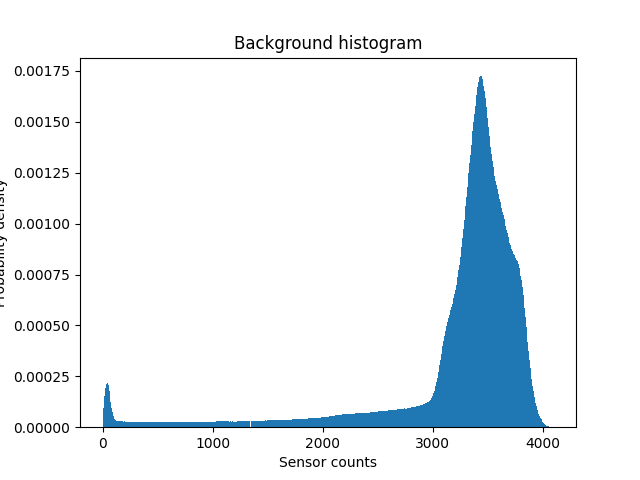

In [7]:
# Check for saturation or blacked out images
maxIntensity = np.nanmax(B.arr)
if (maxIntensity >= 2**bitDepth - 1 ):
    nPixMax = np.sum(B.arr == maxIntensity)
    print("Sensor saturation detected on %i bkgnd pixels per frame" % ( nPixMax/(B.shape()[0])) )
elif (maxIntensity < 64 ):
    print("Low contrast warning: only bottom 6 bits contain data")

# Check histogram
fig=plt.figure()
plt.hist(np.ravel(B.arr),bins=2**(bitDepth-2),density=True);
plt.ylabel("Probability density");
plt.xlabel("Sensor counts");
plt.title("Background histogram");
#plt.hist(np.ravel(I.arr[I.N-1500:I.N-500,...]),bins=2**(bitDepth-2),density=True);


## Background Corrections

In [8]:
# Time-average background
Bavg_mono = np.mean(B.arr,axis=0)

# Boost the minimum level to avoid division by zero later.
# The number chosen for the mask here is arbitrary.
# I let it be 1% of the max intensity.
threshold=0.01*np.nanmax(Bavg_mono)
print("The raw counts for the threshold is: %i" % threshold)
Bavg_monoAdj = Bavg_mono[...]
Bavg_monoAdj[Bavg_monoAdj<threshold]=threshold
print("Background time-average min=%i, max=%i counts" % (Bavg_monoAdj.min(),Bavg_monoAdj.max()))

The raw counts for the threshold is: 40
Background time-average min=40, max=4095 counts


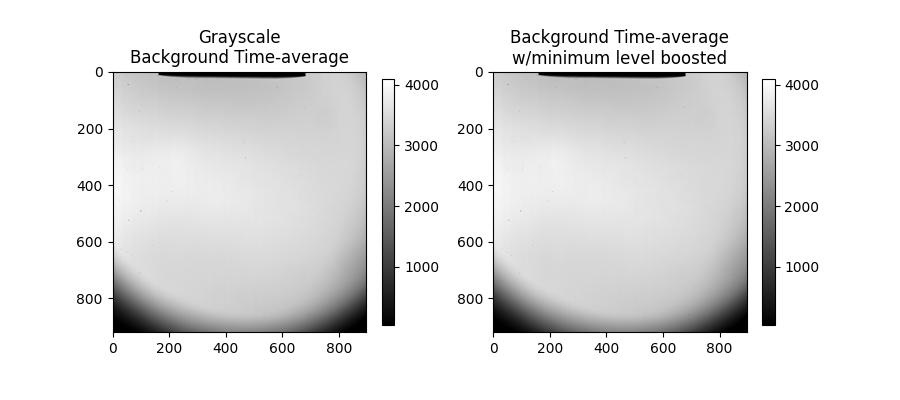

In [9]:
# Plot our progress.
fig=plt.figure(figsize=(9,4))
ax=fig.add_subplot(121)
ax.set_title("Grayscale\nBackground Time-average")
p=ax.imshow(Bavg_mono,cmap='grey')
plt.colorbar(p,shrink=.8)
ax=fig.add_subplot(122)
ax.set_title("Background Time-average\nw/minimum level boosted")
p=ax.imshow(Bavg_monoAdj,cmap='grey')
plt.colorbar(p,shrink=.8);

In [10]:
# Clear background raw images to save RAM.
del(B)

## Time domain check

In [11]:
# Determine usable time range for the spray images and only keep what we need.
spatiallyAveragedIntensity = np.nansum(np.nansum(I.arr, axis=-1),axis=-1)/np.prod(I.shape()[1:])
backgroundAveragedIntensity = np.nanmean(Bavg_mono)
result = spatiallyAveragedIntensity-backgroundAveragedIntensity

In [12]:
# Smooth in time
kernel = np.hanning(256)
s = np.convolve(result, kernel/np.sum(kernel), 'same')

# Find zero crossings as a marker of approximate spray start/stop times.
zeroCross = np.where(np.diff(np.sign(s)) != 0)[0]
t0 = np.min(zeroCross) # Start at first zero crossing
t1 = np.max(zeroCross) # Finish at last zero crossing

# Minimum intensty frame to use later for 'example' images.
sampleFrameNum = np.where(s == np.nanmin(s))[0][0]

print("Sampling period: frame %i-%i" % (t0,t1))

Sampling period: frame 1262-6439


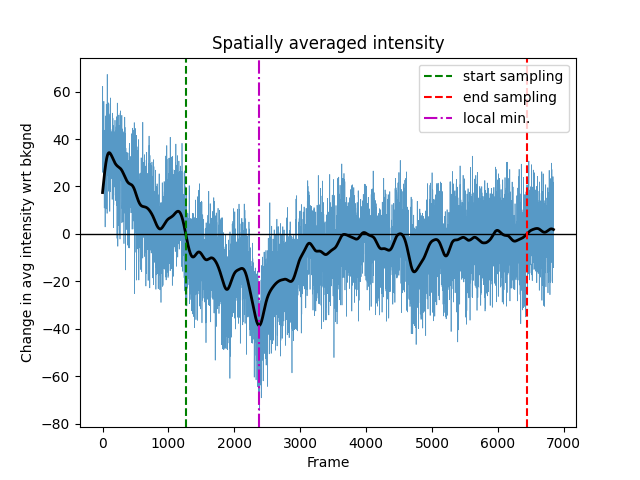

In [13]:
# plot
fig=plt.figure()
plt.plot(result,lw=.5,alpha=.75);
plt.plot(s,lw=2,c='k');
plt.title("Spatially averaged intensity"); plt.xlabel("Frame");
plt.ylabel("Change in avg intensity wrt bkgnd");
plt.axhline(0,c='k',lw=1);
plt.axvline(t0,ls='--',c='g',label='start sampling');
plt.axvline(t1,ls='--',c='r',label='end sampling');
plt.axvline(sampleFrameNum,ls='-.',c='m',label='local min.');
plt.legend();

## Mask generation

Mask generation...


  0%|          | 0/5177 [00:00<?, ?it/s]

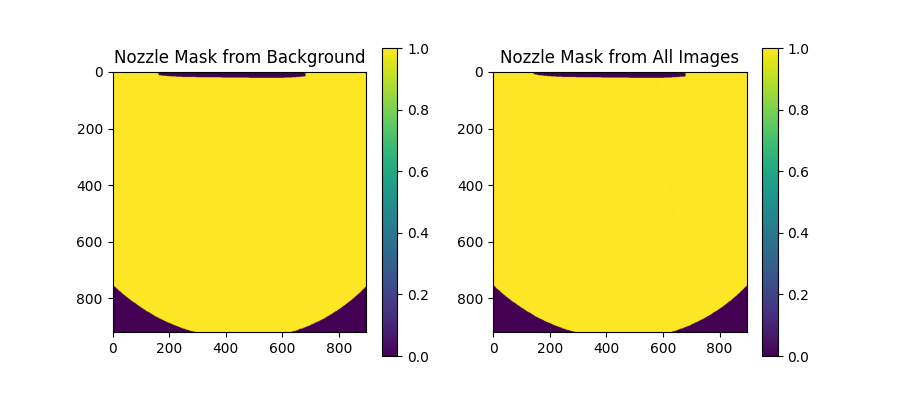

In [14]:
# CREATE MINIMAL MASK FROM BACKGROUND

# threshold factors wrt. 
f1=40 # background threshold 
f2=5 # foreground threshold (don't want to mask the spray itself)

# Mask the parts of the image blocked by the nozzle, where the spray image is below the threshold.
nozzle_mask_b = 1-(Bavg_monoAdj <= f1*threshold)

# GROW MASK DUE TO NOZZLE MOTIONS
nozzle_mask = nozzle_mask_b[...]

# Mask parts of the image sometimes blocked by nozzle as it can move during the event. 
print("Mask generation...")
for i in tqdm(range(t0,t1)):
    local_mask = 1-(I.arr[i,...] <= f2*threshold) 
    nozzle_mask = nozzle_mask & local_mask

nozzle_mask = scipy.ndimage.binary_erosion(nozzle_mask,iterations=2) # remove lone pixels
nozzle_mask = scipy.ndimage.binary_dilation(nozzle_mask,iterations=2) # grow back.

fig=plt.figure(figsize=(9,4))
ax=fig.add_subplot(121)
p=ax.imshow(nozzle_mask_b);
plt.title("Nozzle Mask from Background");
plt.colorbar(p);

ax=fig.add_subplot(122)
p=ax.imshow(nozzle_mask);
plt.title("Nozzle Mask from All Images");
plt.colorbar(p);

## Background removal and masking

In [15]:
# Make arrays to store result in 
Iproc = np.zeros(((t1-t0+1),I.shape()[1],I.shape()[2]))
Imean = np.zeros((I.shape()[1],I.shape()[2]))
Imean2 = np.zeros((I.shape()[1],I.shape()[2]))

# Remove the average background by division, and convert to extinction (dimensionless).
# Apply mask.
# Also make a time-average field while we are in the loop to save compute time later.

for i in tqdm(range(t0,t1)):
    Iproc[i-t0,...] = 1.0 - (I.arr[i,...] / Bavg_monoAdj) # background division
    Iproc[i-t0,...] = Iproc[i-t0,...] * nozzle_mask
    Imean += Iproc[i-t0,...] # keep sum for mean
    Imean2 += Iproc[i-t0,...]**2 # keep sum2 for later stdev

# Post calculate temporal statistics.
Imean  = Imean / float(t1-t0+1) # divide sum to get the mean.
Imean2 = Imean2/ float(t1-t0+1) # divide sum sq.
Istd = np.sqrt(Imean2 - Imean**2)

# Keep a sample raw frame for plotting in case I gets cleared.
Isample = I.arr[sampleFrameNum,...]

  0%|          | 0/5177 [00:00<?, ?it/s]

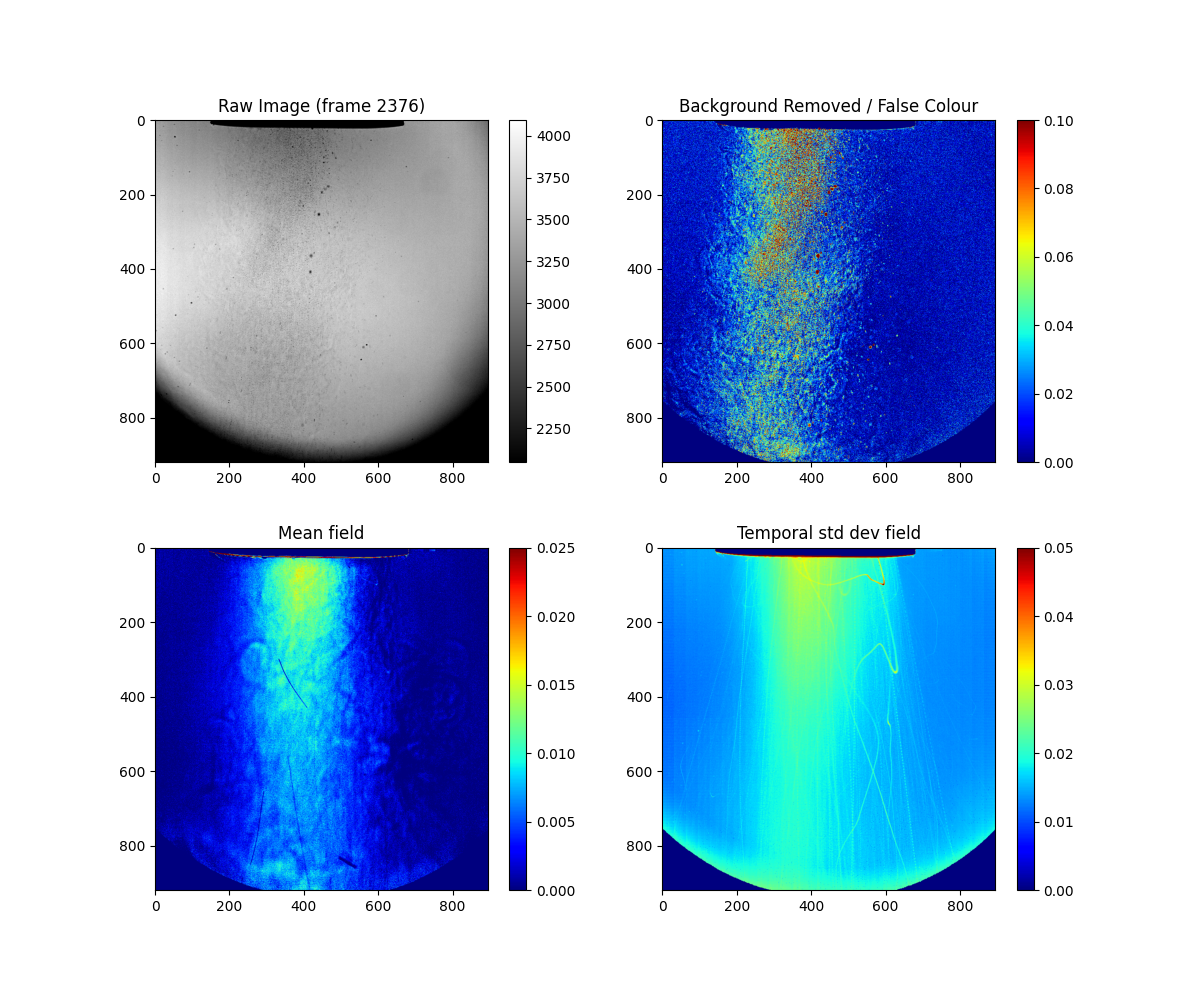

In [16]:
# Plot our progress
fig=plt.figure(figsize=(12,10))
ax=fig.add_subplot(221)
ax.set_title("Raw Image (frame %i)" % sampleFrameNum)
p=ax.imshow(Isample, cmap='gray',vmin=2**(bitDepth-1))
plt.colorbar(p);

ax=fig.add_subplot(222)
ax.set_title("Background Removed / False Colour")
frame=Iproc[sampleFrameNum-t0,...]
p=ax.imshow(frame,cmap='jet',vmin=0,vmax=.1)
plt.colorbar(p);
plt.subplots_adjust(hspace=0.25);

ax=fig.add_subplot(223)
p=ax.imshow(Imean,cmap='jet',vmin=0,vmax=.025)#,vmax=np.nanmean(Imean)+1*np.nanstd(Imean))
plt.colorbar(p);
plt.title("Mean field");

ax=fig.add_subplot(224)
p=ax.imshow(Istd,cmap='jet',vmin=0,vmax=.05)#,vmax=np.nanmean(Istd)+1*np.nanstd(Istd))
plt.colorbar(p);
plt.title("Temporal std dev field");


In [17]:
# Remove raw images to save RAM if we are satisfied with background removal.
del(I)
gc.collect()

## Save preliminary output
For later processing

In [28]:
dest_images = os.path.splitext(source_images)[0]+'.h5'
start_time = time.perf_counter()
with h5py.File(dest_images,'w') as H:
    G=H.create_group('bkgnd_removed_images')
    for var in ['nozzle_mask','Imean','Istd']:
        d=G.create_dataset(var,data=eval(var))
    for a in ['width','height','bitDepth','threshold','t0','t1','f1','f2']:
        G.attrs[a] = eval(a)
    d=G.create_dataset('Iproc',Iproc.shape) # no compression for speed.
    for i in tqdm(range(Iproc.shape[0])):
        d[i,...]=Iproc[i,...]
end_time = time.perf_counter()
print("Wrote %s [%.1f MB in %.1f s]" % (dest_images,os.path.getsize(dest_images)/1048576.,end_time-start_time))

  0%|          | 0/5178 [00:00<?, ?it/s]

Wrote /Users/dduke/Desktop/20kHz_896x920_134_0.3Or08L_cone901.3Dep_MK6__S0001.h5 [16295.8 MB in 228.7 s]


In [27]:
start_time = time.perf_counter()
dest_images = os.path.splitext(source_images)[0]+'.npy'
np.save(dest_images, Iproc, allow_pickle=False)
end_time = time.perf_counter()
print("Wrote %s [%.1f MB in %.1f s]" % (dest_images,os.path.getsize(dest_images)/1048576.,end_time-start_time))

OSError: 4268328960 requested and 2147482624 written